In [3]:
## Prueba de la generación de trayectorias y movimiento del robot 7 ejes

In [4]:
import numpy as np
import mujoco
from collections import namedtuple
import matplotlib.pyplot as plt


## Cinématica Inversa

In [5]:
def solve_ik_6dof(model, data, goal_pos, goal_quat=None, max_iter=100, tolerance=0.02, alpha_pos=0.8, alpha_rot=0.5):
    """
    Cinemática inversa para posición y orientación 
    
    Args:
        model: modelo de MuJoCo
        data: datos de MuJoCo
        goal_pos: posición objetivo [x, y, z]
        goal_quat: orientación objetivo [w, x, y, z] (opcional)
        max_iter: máximo número de iteraciones
        tolerance: tolerancia de error
        alpha_pos: ganancia para posición
        alpha_rot: ganancia para orientación
    """
    jacp = np.zeros((3, model.nv))  # Jacobiano de posición
    jacr = np.zeros((3, model.nv))  # Jacobiano de rotación
    end_effector_id = model.body('wrist_3_link').id
    
    # IDs de los joints del UR10 (SIN el eje lineal)
    ur10_joint_names = [
        "shoulder_pan_joint",
        "shoulder_lift_joint", 
        "elbow_joint",
        "wrist_1_joint",
        "wrist_2_joint",
        "wrist_3_joint"
    ]
    
    ur10_joint_ids = []
    for name in ur10_joint_names:
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        ur10_joint_ids.append(joint_id)
    
    # Guardar posición inicial del eje lineal
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    posicion_eje_lineal = data.qpos[linear_joint_id]
    
    for iteration in range(max_iter):
        # Posición actual del efector final
        current_pos = data.body(end_effector_id).xpos
        current_quat = data.body(end_effector_id).xquat  # [w, x, y, z]
        
        # Error de posición
        error_pos = np.subtract(goal_pos, current_pos)
        error_pos_norm = np.linalg.norm(error_pos)
        
        # Error de orientación (si se especifica)
        if goal_quat is not None:
            # Convertir cuaterniones a vectores de rotación
            error_rot = quaternion_error(goal_quat, current_quat)
            error_rot_norm = np.linalg.norm(error_rot)
            
            # Error total
            total_error = error_pos_norm + error_rot_norm
            
            # Verificar convergencia
            if error_pos_norm < tolerance and error_rot_norm < tolerance:
                return True, total_error, iteration
        else:
            # Solo posición
            if error_pos_norm < tolerance:
                return True, error_pos_norm, iteration
        
        # Calcular Jacobianos
        mujoco.mj_jac(model, data, jacp, jacr, current_pos, end_effector_id)
        
        # Extraer SOLO las columnas del Jacobiano correspondientes a los joints del UR10
        jac_pos_ur10 = jacp[:, ur10_joint_ids]
        jac_rot_ur10 = jacr[:, ur10_joint_ids]
        
        if goal_quat is not None:
            # IK con posición y orientación (6 DOF)
            # Combinar errores y jacobianos
            error_combined = np.concatenate([alpha_pos * error_pos, alpha_rot * error_rot])
            jac_combined = np.vstack([alpha_pos * jac_pos_ur10, alpha_rot * jac_rot_ur10])
            
            # Pseudoinversa amortiguada
            damping = 1e-4
            jac_T = jac_combined.T
            jac_pinv = jac_T @ np.linalg.inv(jac_combined @ jac_T + damping * np.eye(6))
            delta_q_ur10 = jac_pinv @ error_combined
        else:
            # Solo posición (3 DOF)
            jac_pinv = np.linalg.pinv(jac_pos_ur10)
            delta_q_ur10 = alpha_pos * jac_pinv @ error_pos
        
        # Actualizar SOLO los joints del UR10
        for i, joint_id in enumerate(ur10_joint_ids):
            data.qpos[joint_id] += delta_q_ur10[i]
        
        # MANTENER el eje lineal fijo
        data.qpos[linear_joint_id] = posicion_eje_lineal
        
        mujoco.mj_forward(model, data)
    
    # No convergió
    current_pos = data.body(end_effector_id).xpos
    error_pos_norm = np.linalg.norm(np.subtract(goal_pos, current_pos))
    
    if goal_quat is not None:
        current_quat = data.body(end_effector_id).xquat
        error_rot = quaternion_error(goal_quat, current_quat)
        error_rot_norm = np.linalg.norm(error_rot)
        total_error = error_pos_norm + error_rot_norm
        return False, total_error, max_iter
    else:
        return False, error_pos_norm, max_iter

def quaternion_error(q_target, q_current):
    """
    Calcula el error de orientación entre dos cuaterniones
    Retorna vector de error en el espacio tangente SO(3)
    """
    # Normalizar cuaterniones
    q_target = q_target / np.linalg.norm(q_target)
    q_current = q_current / np.linalg.norm(q_current)
    
    # Cuaternión de error: q_error = q_target * q_current^(-1)
    q_current_inv = np.array([q_current[0], -q_current[1], -q_current[2], -q_current[3]])
    q_error = quaternion_multiply(q_target, q_current_inv)
    
    # Convertir a vector de rotación (parte vectorial * 2)
    if q_error[0] < 0:  # Asegurar que w >= 0 para minimizar ángulo
        q_error = -q_error
    
    # Error como vector de rotación
    error_rot = 2.0 * q_error[1:4]  # [x, y, z] components
    return error_rot

def quaternion_multiply(q1, q2):
    """Multiplica dos cuaterniones [w, x, y, z]"""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    
    return np.array([w, x, y, z])

def rpy_to_quaternion(roll, pitch, yaw):
    """Convierte ángulos RPY (radianes) a cuaternión [w, x, y, z]"""
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    
    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy
    
    return np.array([w, x, y, z])

def quaternion_to_rpy(quat):
    """Convierte cuaternión [w, x, y, z] a ángulos RPY"""
    w, x, y, z = quat
    
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    
    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp)
    else:
        pitch = np.arcsin(sinp)
    
    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    
    return np.array([roll, pitch, yaw])

def verificar_punto_con_orientacion(model, data, punto, orientacion=None, posicion_eje=0.0):
    """
    Verifica un punto [x,y,z] con orientación opcional y muestra imagen
    
    Args:
        model: modelo de MuJoCo
        data: datos de MuJoCo
        punto: [x, y, z] coordenadas del punto objetivo
        orientacion: [roll, pitch, yaw] en radianes (opcional)
        posicion_eje: posición fija del eje lineal
    """
    print(f" Verificando punto: {punto}")
    if orientacion is not None:
        print(f" Con orientación RPY: {np.round(orientacion, 3)} rad")
    
    # Resetear
    mujoco.mj_resetData(model, data)
    
    # FIJAR el eje lineal ANTES de empezar
    fijar_eje_lineal(model, data, posicion_eje)
    mujoco.mj_forward(model, data)
    
    pos_inicial = data.body('wrist_3_link').xpos.copy()
    quat_inicial = data.body('wrist_3_link').xquat.copy()
    rpy_inicial = quaternion_to_rpy(quat_inicial)
    
    # Convertir orientación a cuaternión si se especifica
    goal_quat = None
    if orientacion is not None:
        goal_quat = rpy_to_quaternion(orientacion[0], orientacion[1], orientacion[2])
    
    # Resolver IK con orientación
    exito, error, iteraciones = solve_ik_6dof(model, data, punto, goal_quat)
    
    # Verificar que el eje lineal NO se movió
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    posicion_final_eje = data.qpos[linear_joint_id]
    
    # Obtener configuración final del UR10
    ur10_joint_names = [
        "shoulder_pan_joint", "shoulder_lift_joint", "elbow_joint",
        "wrist_1_joint", "wrist_2_joint", "wrist_3_joint"
    ]
    
    config_ur10 = []
    for name in ur10_joint_names:
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        config_ur10.append(data.qpos[joint_id])
    
    # Posición y orientación final
    pos_final = data.body('wrist_3_link').xpos.copy()
    quat_final = data.body('wrist_3_link').xquat.copy()
    rpy_final = quaternion_to_rpy(quat_final)
    
    distancia_real = np.linalg.norm(np.array(punto) - pos_final)
    
    # Error de orientación
    error_orientacion = 0.0
    if orientacion is not None:
        error_orientacion = np.linalg.norm(np.array(orientacion) - rpy_final)
    
    # Crear renderer
    renderer = mujoco.Renderer(model, height=480, width=640)
    
    # Configurar cámara
    camera = mujoco.MjvCamera()
    mujoco.mjv_defaultFreeCamera(model, camera)
    camera.distance = 5
    camera.azimuth = 45
    camera.elevation = -15
    camera.lookat = [0, 0, 0]
    
    # Capturar imagen
    mujoco.mj_step(model, data)
    renderer.update_scene(data, camera)
    imagen = renderer.render()
    
    # Mostrar resultados
    print(f" Resultados:")
    print(f"  IK exitoso: {' Sí' if exito else ' No'}")
    print(f"  Error total: {error:.4f}")
    print(f"  Iteraciones: {iteraciones}")
    print(f"  Eje lineal: {posicion_eje:.3f}m -> {posicion_final_eje:.3f}m {'' if abs(posicion_final_eje - posicion_eje) < 0.001 else '❌'}")
    print(f"  Configuración UR10: {np.round(config_ur10, 3)}")
    print(f"  Posición inicial: {np.round(pos_inicial, 3)}")
    print(f"  Posición final: {np.round(pos_final, 3)}")
    print(f"  Distancia real: {distancia_real:.4f}")
    
    if orientacion is not None:
        print(f"  RPY inicial: {np.round(rpy_inicial, 3)}")
        print(f"  RPY final: {np.round(rpy_final, 3)}")
        print(f"  Error orientación: {error_orientacion:.4f}")
    
    if distancia_real < 0.05 and (orientacion is None or error_orientacion < 0.1):
        print(f"  ¡Punto ALCANZABLE!")
    else:
        print(f"    Punto/orientación DIFÍCIL de alcanzar")
    
    # Mostrar imagen
    plt.figure(figsize=(14, 6))
    
    # Imagen del robot
    plt.subplot(1, 2, 1)
    plt.imshow(imagen)
    if orientacion is not None:
        plt.title(f"Robot con pose 6DOF (Eje: {posicion_eje:.2f}m)\nPos: {np.round(punto, 3)}, RPY: {np.round(orientacion, 3)}")
    else:
        plt.title(f"Robot en posición (Eje: {posicion_eje:.2f}m)\nObjetivo: {np.round(punto, 3)}")
    plt.axis('off')
    
    # Información
    plt.subplot(1, 2, 2)
    if orientacion is not None:
        info_text = f"""OBJETIVO:
Posición: {np.round(punto, 3)}
Orientación RPY: {np.round(orientacion, 3)}

RESULTADO: {'ALCANZABLE' if exito else ' NO ALCANZABLE'}

Error total: {error:.4f}
Iteraciones: {iteraciones}
Distancia real: {distancia_real:.4f}
Error orientación: {error_orientacion:.4f}

Eje lineal: {posicion_eje:.3f}m (FIJO)

CONFIGURACIÓN UR10:
q1 (shoulder_pan): {config_ur10[0]:.3f}
q2 (shoulder_lift): {config_ur10[1]:.3f}
q3 (elbow): {config_ur10[2]:.3f}
q4 (wrist_1): {config_ur10[3]:.3f}
q5 (wrist_2): {config_ur10[4]:.3f}
q6 (wrist_3): {config_ur10[5]:.3f}

POSE FINAL:
Posición: {np.round(pos_final, 3)}
RPY: {np.round(rpy_final, 3)}"""
    else:
        info_text = f"""OBJETIVO: {np.round(punto, 3)}

RESULTADO: {'ALCANZABLE' if exito else ' NO ALCANZABLE'}

Error: {error:.4f}
Iteraciones: {iteraciones}
Distancia real: {distancia_real:.4f}

Eje lineal: {posicion_eje:.3f}m (FIJO)

CONFIGURACIÓN UR10:
q1 (shoulder_pan): {config_ur10[0]:.3f}
q2 (shoulder_lift): {config_ur10[1]:.3f}
q3 (elbow): {config_ur10[2]:.3f}
q4 (wrist_1): {config_ur10[3]:.3f}
q5 (wrist_2): {config_ur10[4]:.3f}
q6 (wrist_3): {config_ur10[5]:.3f}

Posición final: {np.round(pos_final, 3)}
RPY final: {np.round(rpy_final, 3)}"""
    
    plt.text(0.05, 0.5, info_text, fontsize=10, verticalalignment='center', 
             transform=plt.gca().transAxes, family='monospace')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'punto': punto,
        'orientacion': orientacion,
        'exito': exito,
        'error': error,
        'distancia_real': distancia_real,
        'error_orientacion': error_orientacion,
        'pos_final': pos_final,
        'rpy_final': rpy_final,
        'config_ur10': config_ur10,
        'eje_se_movio': abs(posicion_final_eje - posicion_eje) > 0.001
    }

def fijar_eje_lineal(model, data, posicion=0.0):
    """Fija el eje lineal en una posición específica"""
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    data.qpos[linear_joint_id] = posicion
    data.ctrl[0] = posicion
    print(f" Eje lineal fijado en: {posicion:.3f}m")

##  Ejemplo de uso

In [6]:
marcadores = {
    'estiva_1_rojo': [-1.0, -0.4, 0.45],
    'estiva_1_verde': [-1.2, -0.8, 0.35],
    'estiva_2_azul': [-0.15, -0.45, 0.55],
    'estiva_3_amarillo': [1.0, -0.6, 0.65],
    'mesa_naranja': [1.05, 0.5, 0.33],
    'mesa_cian': [1.65, 0.35, 0.29],
    'mesa_magenta': [1.95, 0.5, 0.39],
    'mesa_azul_claro': [0.95, 0.45, 0.31]
}

orientaciones = {
    'paralelo_piso': [0, 0, 0],           # Completamente horizontal
    'ligeramente_inclinado': [0, 0.1, 0], # 5.7° hacia abajo
    'rotado_90_grados': [0, 0, 1.57],     # Girado 90° en Z
    'invertido': [3.14, 0, 0],            # Volteado 180°
    'diagonal_suave': [0, 0.2, 0.3],      # Orientación diagonal
}

In [7]:
marcadores['estiva_1_rojo']
orientaciones['invertido']

[3.14, 0, 0]

 Verificador con orientación (6DOF)

--- VERIFICACIÓN SOLO POSICIÓN ---
 Verificando punto: [0.3, -0.17, 1.8]
 Eje lineal fijado en: 0.500m
 Resultados:
  IK exitoso:  Sí
  Error total: 0.0058
  Iteraciones: 6
  Eje lineal: 0.500m -> 0.500m 
  Configuración UR10: [-0.02  -1.805  0.623  5.985 -0.     0.   ]
  Posición inicial: [-0.684 -0.174  0.561]
  Posición final: [ 0.302 -0.17   1.795]
  Distancia real: 0.0058
  ¡Punto ALCANZABLE!


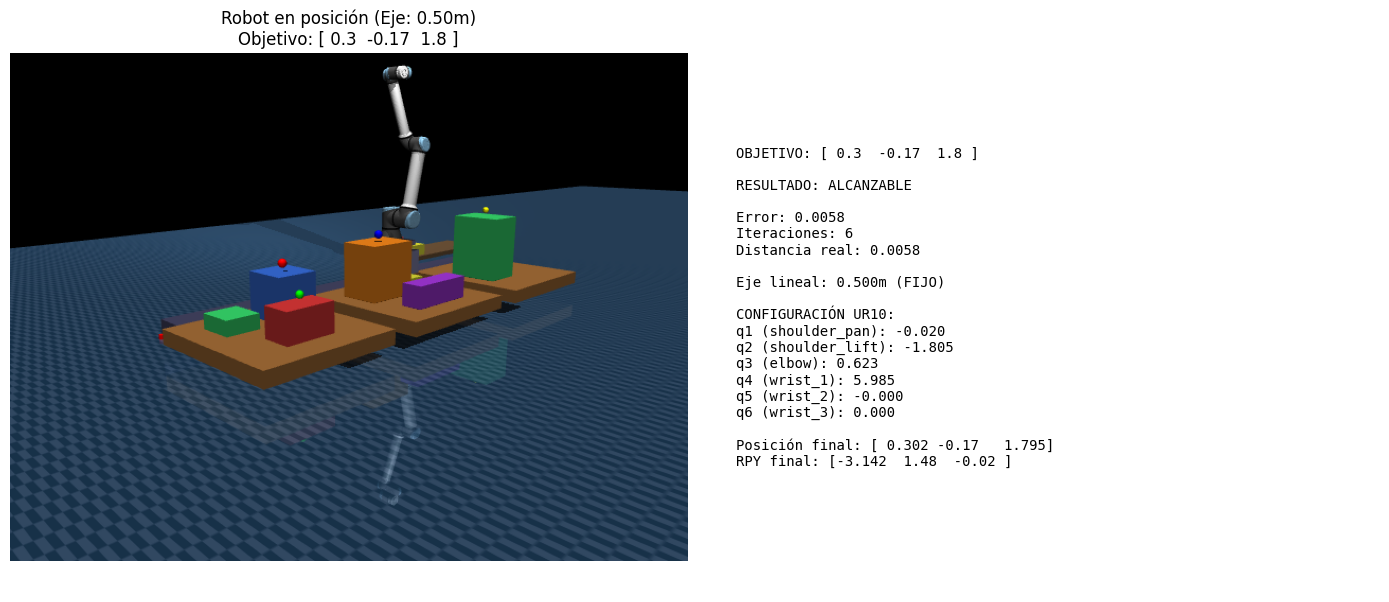


--- VERIFICACIÓN MÚLTIPLE 6DOF ---

--- Pose 1/4 ---
 Verificando punto: [-1.0, -0.4, 0.45]
 Con orientación RPY: [3.14 0.   0.  ] rad
 Eje lineal fijado en: 0.000m
 Resultados:
  IK exitoso:  Sí
  Error total: 0.0136
  Iteraciones: 4
  Eje lineal: 0.000m -> 0.000m 
  Configuración UR10: [ 0.218 -0.342  0.922 -0.591  0.212  0.011]
  Posición inicial: [-1.184 -0.174  0.561]
  Posición final: [-0.994 -0.398  0.454]
  Distancia real: 0.0074
  RPY inicial: [3.142 0.    0.   ]
  RPY final: [ 3.139 -0.     0.006]
  Error orientación: 0.0062
  ¡Punto ALCANZABLE!


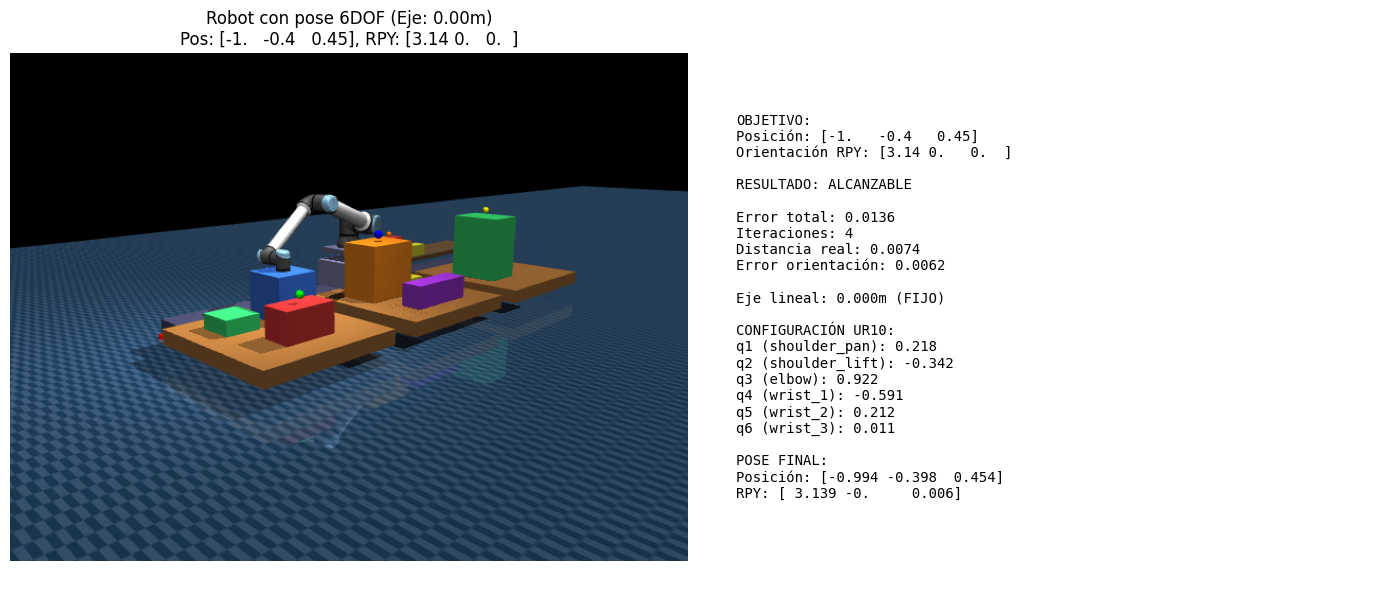


--- Pose 2/4 ---
 Verificando punto: [-1.2, -0.8, 0.35]
 Con orientación RPY: [3.14 0.   0.  ] rad
 Eje lineal fijado en: 0.000m
 Resultados:
  IK exitoso:  No
  Error total: 2.6232
  Iteraciones: 100
  Eje lineal: 0.000m -> 0.000m 
  Configuración UR10: [ -5.703   5.309  -2.385 -43.567  -7.531  21.43 ]
  Posición inicial: [-1.184 -0.174  0.561]
  Posición final: [ 0.254 -0.042  1.183]
  Distancia real: 1.8389
  RPY inicial: [3.142 0.    0.   ]
  RPY final: [-2.929  0.488 -0.562]
  Error orientación: 6.1141
    Punto/orientación DIFÍCIL de alcanzar


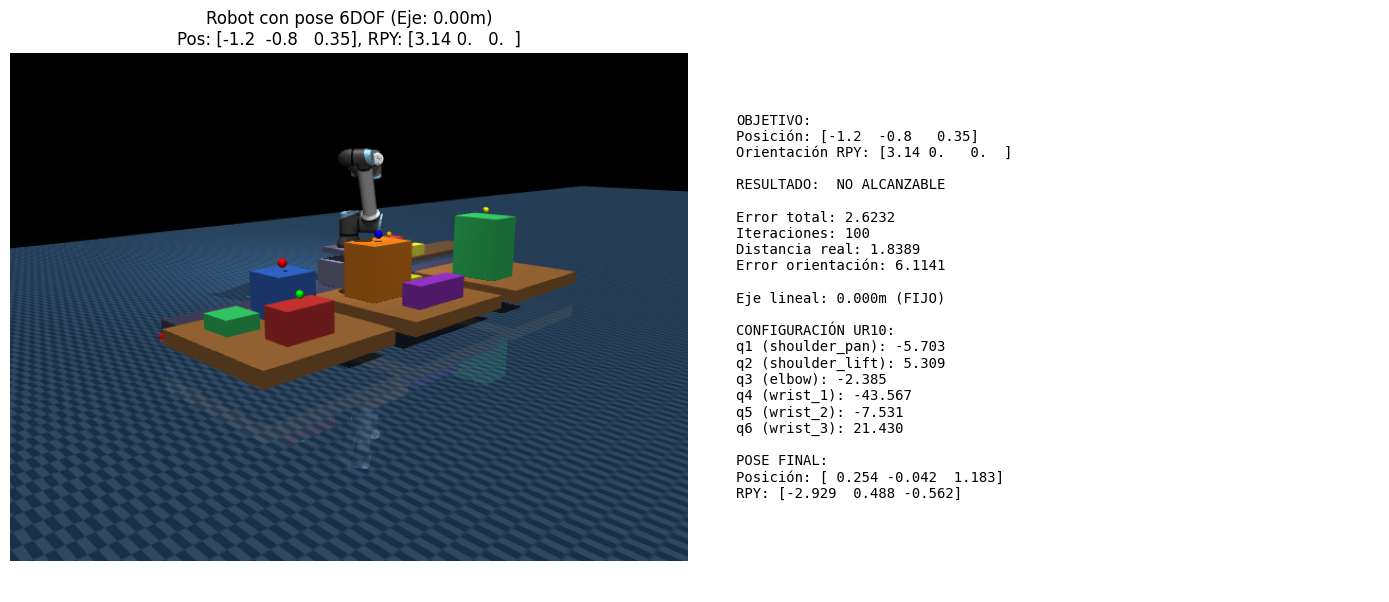


--- Pose 3/4 ---
 Verificando punto: [-0.15, -0.45, 0.55]
 Con orientación RPY: [3.14 0.   0.  ] rad
 Eje lineal fijado en: 0.000m
 Resultados:
  IK exitoso:  Sí
  Error total: 0.0154
  Iteraciones: 18
  Eje lineal: 0.000m -> 0.000m 
  Configuración UR10: [-11.705  -6.817   2.267 -11.155   5.425 -28.284]
  Posición inicial: [-1.184 -0.174  0.561]
  Posición final: [-0.152 -0.444  0.55 ]
  Distancia real: 0.0064
  RPY inicial: [3.142 0.    0.   ]
  RPY final: [-3.139e+00  7.000e-03  3.000e-03]
  Error orientación: 6.2790
    Punto/orientación DIFÍCIL de alcanzar


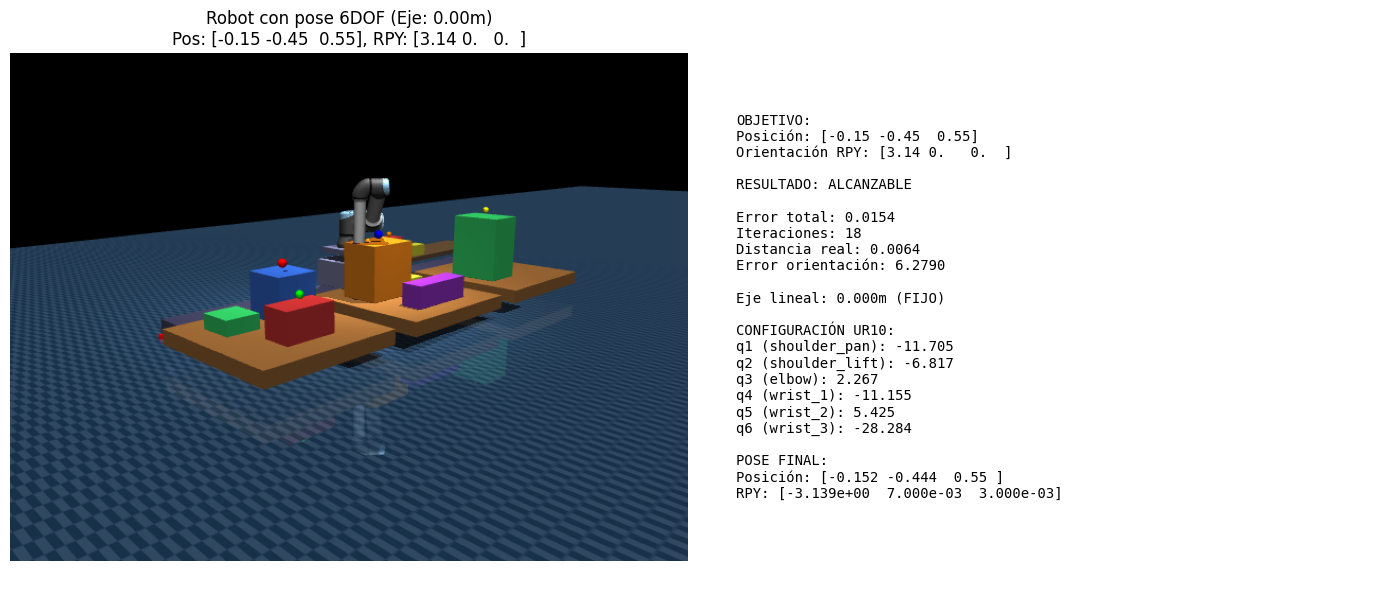


--- Pose 4/4 ---
 Verificando punto: [1.0, -0.6, 0.65]
 Con orientación RPY: [3.14 0.   0.  ] rad
 Eje lineal fijado en: 0.000m
 Resultados:
  IK exitoso:  Sí
  Error total: 0.0040
  Iteraciones: 7
  Eje lineal: 0.000m -> 0.000m 
  Configuración UR10: [ -0.391  -3.467   6.689  12.489   0.391 -15.711]
  Posición inicial: [-1.184 -0.174  0.561]
  Posición final: [ 0.997 -0.599  0.651]
  Distancia real: 0.0037
  RPY inicial: [3.142 0.    0.   ]
  RPY final: [ 3.14 -0.   -0.  ]
  Error orientación: 0.0003
  ¡Punto ALCANZABLE!


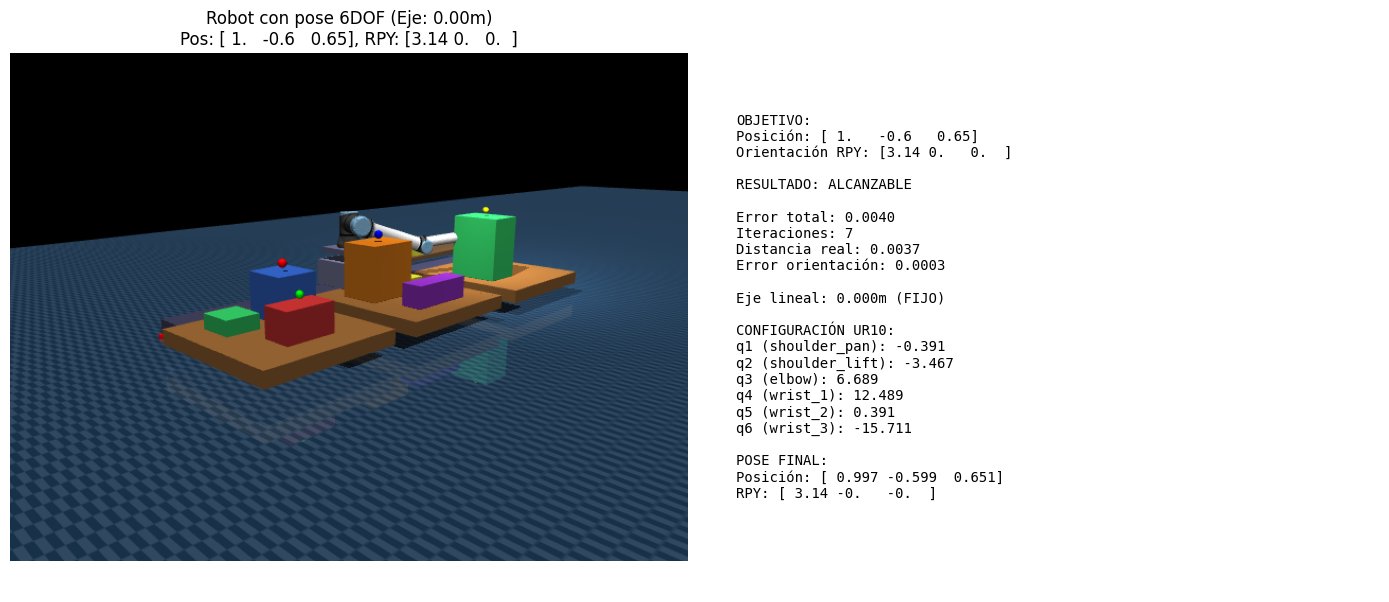

In [8]:
# ===== EJEMPLO DE USO =====
if __name__ == "__main__":
    # Cargar modelo
    model = mujoco.MjModel.from_xml_path("wherehouse_system.xml")
    data = mujoco.MjData(model)
    
    print(" Verificador con orientación (6DOF)")
    print("=" * 45)
    
    # Ejemplo 1: Solo posición (3DOF)
    print(f"\n--- VERIFICACIÓN SOLO POSICIÓN ---")
    punto_prueba = [0.3, -0.17, 1.8]
    resultado1 = verificar_punto_con_orientacion(model, data, punto_prueba, posicion_eje=0.5)
    

    
    # Ejemplo 3: Múltiples poses con orientación
    print(f"\n--- VERIFICACIÓN MÚLTIPLE 6DOF ---")
    poses_prueba = [
        (marcadores['estiva_1_rojo'], orientaciones['invertido']),       # Sin rotación
        (marcadores['estiva_1_verde'], orientaciones['invertido']),       # Pitch
        (marcadores['estiva_2_azul'], orientaciones['invertido']),       # Yaw
        (marcadores['estiva_3_amarillo'], orientaciones['invertido']),     # Combinado
    ]
    
    for i, (pos, orient) in enumerate(poses_prueba):
        print(f"\n--- Pose {i+1}/4 ---")
        resultado = verificar_punto_con_orientacion(model, data, pos, orient, posicion_eje=0.0)


🤖 Verificador IK CORREGIDO con Cinemática Directa

--- PRUEBA: ORIENTACIÓN PARALELA AL PISO ---
🎯 Verificando punto: [0.5, -0.2, 1.8]
🔄 Con orientación RPY: [0 0 0] rad
🔒 Eje lineal fijado en: 0.000m
📍 Posición inicial REAL: [-1.184 -0.174  0.561]
📐 RPY inicial REAL: [3.142 0.    0.   ]
🎯 Cuaternión objetivo: [1. 0. 0. 0.]
🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:
  Config completa: [  0.      2.432  -1.416   0.663  16.445   0.714 -12.546]
  FK posición: [ 0.499 -0.199  1.797]
  FK RPY: [-0.011  0.008  0.005]
  Coincide con final: True
📊 Resultados:
  IK exitoso: ✅ Sí
  Error total: 0.0172
  Iteraciones: 12
  Eje lineal: 0.000m -> 0.000m ✅
  Configuración UR10: [  2.432  -1.416   0.663  16.445   0.714 -12.546]
  Posición objetivo: [ 0.5 -0.2  1.8]
  Posición final: [ 0.499 -0.199  1.797]
  Distancia real: 0.0028
  RPY objetivo: [0 0 0]
  RPY final: [-0.011  0.008  0.005]
  Error orientación: 0.0144
  🎉 ¡Punto ALCANZABLE!


C:\Users\samue\AppData\Local\Temp\ipykernel_19140\749071773.py:412: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\samue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


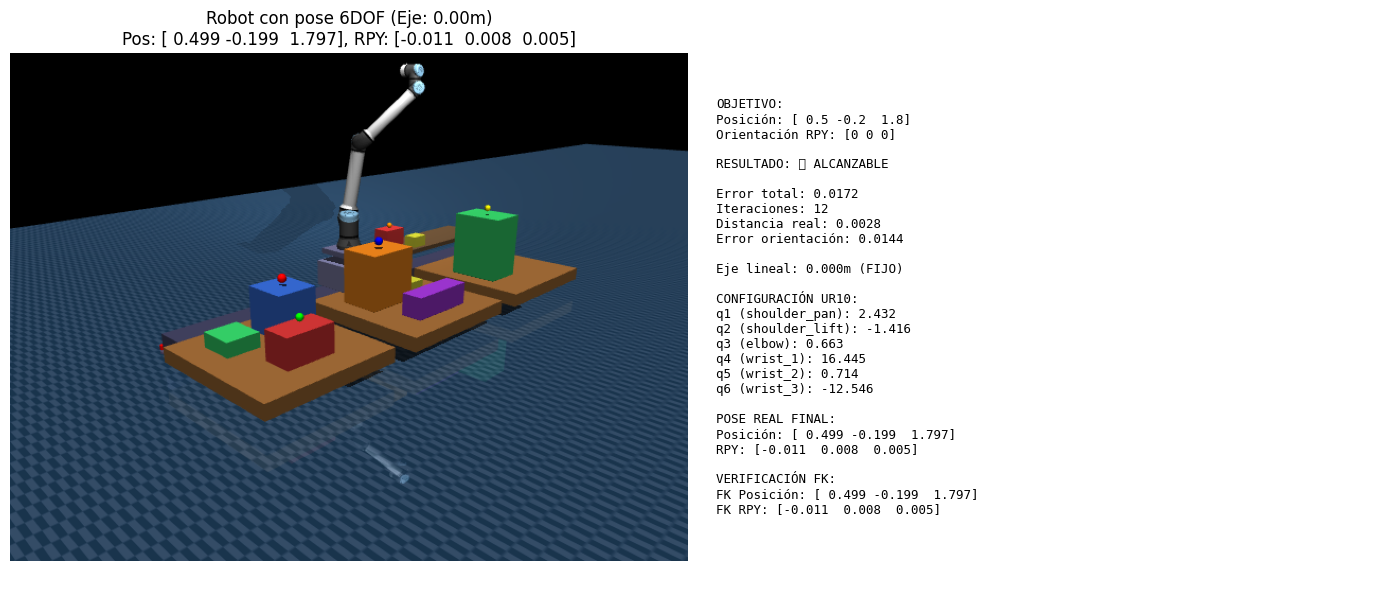


--- PRUEBA: SOLO POSICIÓN ---
🎯 Verificando punto: [0.3, -0.3, 1.7]
🔒 Eje lineal fijado en: 0.000m
📍 Posición inicial REAL: [-1.184 -0.174  0.561]
📐 RPY inicial REAL: [3.142 0.    0.   ]
🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:
  Config completa: [ 0.    -0.364 -2.525  1.02   5.406 -0.     0.   ]
  FK posición: [ 0.293 -0.298  1.692]
  FK RPY: [-0.     0.76   2.778]
  Coincide con final: True
📊 Resultados:
  IK exitoso: ✅ Sí
  Error total: 0.0105
  Iteraciones: 13
  Eje lineal: 0.000m -> 0.000m ✅
  Configuración UR10: [-0.364 -2.525  1.02   5.406 -0.     0.   ]
  Posición objetivo: [ 0.3 -0.3  1.7]
  Posición final: [ 0.293 -0.298  1.692]
  Distancia real: 0.0105
  🎉 ¡Punto ALCANZABLE!


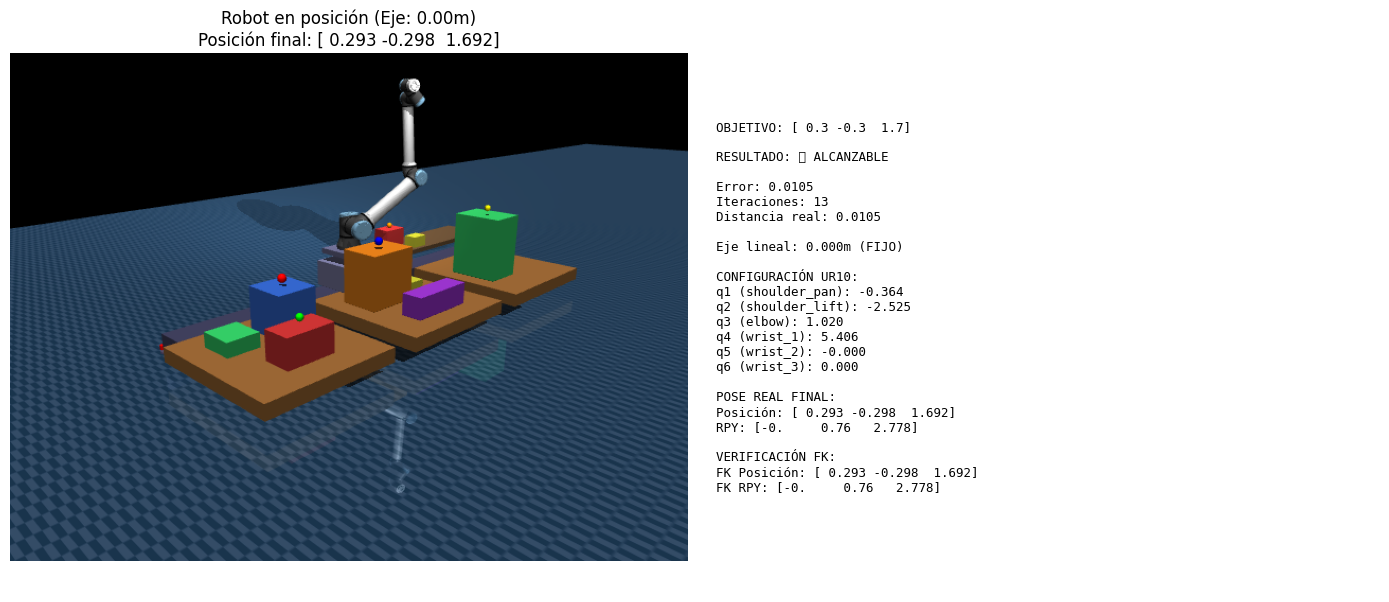


--- PRUEBA: VERIFICAR CONFIGURACIÓN CONOCIDA ---
Config: [ 0.5   0.   -1.57  0.   -1.57  0.    0.  ]
FK Posición: [ 0.499 -0.174  1.985]
FK RPY: [0.000e+00 2.000e-03 3.142e+00]

✅ ¡Verificación completada con cinemática directa!


In [9]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt

def forward_kinematics(model, data, q_config, body_name="wrist_3_link"):
    """
    Calcula la cinemática directa - establece configuración y retorna pose
    
    Args:
        model: modelo de MuJoCo
        data: datos de MuJoCo
        q_config: configuración de joints [linear, q1, q2, q3, q4, q5, q6]
        body_name: nombre del cuerpo a evaluar
    
    Returns:
        pos: posición [x, y, z]
        quat: cuaternión [w, x, y, z]
        rpy: ángulos RPY [roll, pitch, yaw]
    """
    # Nombres de todos los joints en orden
    joint_names = [
        "linear_joint",
        "shoulder_pan_joint",
        "shoulder_lift_joint", 
        "elbow_joint",
        "wrist_1_joint",
        "wrist_2_joint",
        "wrist_3_joint"
    ]
    
    # Establecer configuración
    for i, joint_name in enumerate(joint_names):
        if i < len(q_config):
            joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
            data.qpos[joint_id] = q_config[i]
    
    # Calcular cinemática directa
    mujoco.mj_forward(model, data)
    
    # Obtener pose del cuerpo especificado
    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, body_name)
    pos = data.xpos[body_id].copy()
    quat = data.xquat[body_id].copy()
    rpy = quaternion_to_rpy(quat)
    
    return pos, quat, rpy

def solve_ik_6dof_corrected(model, data, goal_pos, goal_quat=None, max_iter=100, tolerance=0.02, alpha_pos=1.0, alpha_rot=0.5):
    """
    Cinemática inversa CORREGIDA para posición y orientación 
    """
    jacp = np.zeros((3, model.nv))  # Jacobiano de posición
    jacr = np.zeros((3, model.nv))  # Jacobiano de rotación
    end_effector_id = model.body('wrist_3_link').id
    
    # IDs de los joints del UR10 (SIN el eje lineal)
    ur10_joint_names = [
        "shoulder_pan_joint",
        "shoulder_lift_joint", 
        "elbow_joint",
        "wrist_1_joint",
        "wrist_2_joint",
        "wrist_3_joint"
    ]
    
    ur10_joint_ids = []
    for name in ur10_joint_names:
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        ur10_joint_ids.append(joint_id)
    
    # Guardar posición inicial del eje lineal
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    posicion_eje_lineal = data.qpos[linear_joint_id]
    
    for iteration in range(max_iter):
        # IMPORTANTE: Actualizar la simulación ANTES de calcular errores
        mujoco.mj_forward(model, data)
        
        # Posición actual del efector final
        current_pos = data.body(end_effector_id).xpos.copy()
        current_quat = data.body(end_effector_id).xquat.copy()  # [w, x, y, z]
        
        # Error de posición
        error_pos = np.subtract(goal_pos, current_pos)
        error_pos_norm = np.linalg.norm(error_pos)
        
        # Error de orientación (si se especifica)
        if goal_quat is not None:
            # Convertir cuaterniones a vectores de rotación
            error_rot = quaternion_error(goal_quat, current_quat)
            error_rot_norm = np.linalg.norm(error_rot)
            
            # Error total
            total_error = error_pos_norm + error_rot_norm
            
            # Verificar convergencia
            if error_pos_norm < tolerance and error_rot_norm < tolerance:
                return True, total_error, iteration
        else:
            # Solo posición
            if error_pos_norm < tolerance:
                return True, error_pos_norm, iteration
        
        # Calcular Jacobianos EN LA POSICIÓN ACTUAL
        mujoco.mj_jac(model, data, jacp, jacr, current_pos, end_effector_id)
        
        # Extraer SOLO las columnas del Jacobiano correspondientes a los joints del UR10
        jac_pos_ur10 = jacp[:, ur10_joint_ids]
        jac_rot_ur10 = jacr[:, ur10_joint_ids]
        
        if goal_quat is not None:
            # IK con posición y orientación (6 DOF)
            # Combinar errores y jacobianos
            error_combined = np.concatenate([alpha_pos * error_pos, alpha_rot * error_rot])
            jac_combined = np.vstack([alpha_pos * jac_pos_ur10, alpha_rot * jac_rot_ur10])
            
            # Pseudoinversa amortiguada
            damping = 1e-4
            jac_T = jac_combined.T
            jac_pinv = jac_T @ np.linalg.inv(jac_combined @ jac_T + damping * np.eye(6))
            delta_q_ur10 = jac_pinv @ error_combined
        else:
            # Solo posición (3 DOF)
            jac_pinv = np.linalg.pinv(jac_pos_ur10)
            delta_q_ur10 = alpha_pos * jac_pinv @ error_pos
        
        # Aplicar paso más conservador
        step_size = 0.5
        delta_q_ur10 = step_size * delta_q_ur10
        
        # Actualizar SOLO los joints del UR10
        for i, joint_id in enumerate(ur10_joint_ids):
            data.qpos[joint_id] += delta_q_ur10[i]
        
        # MANTENER el eje lineal fijo
        data.qpos[linear_joint_id] = posicion_eje_lineal
    
    # No convergió - calcular error final
    mujoco.mj_forward(model, data)
    current_pos = data.body(end_effector_id).xpos
    error_pos_norm = np.linalg.norm(np.subtract(goal_pos, current_pos))
    
    if goal_quat is not None:
        current_quat = data.body(end_effector_id).xquat
        error_rot = quaternion_error(goal_quat, current_quat)
        error_rot_norm = np.linalg.norm(error_rot)
        total_error = error_pos_norm + error_rot_norm
        return False, total_error, max_iter
    else:
        return False, error_pos_norm, max_iter

def quaternion_error(q_target, q_current):
    """Calcula el error de orientación entre dos cuaterniones"""
    # Normalizar cuaterniones
    q_target = q_target / np.linalg.norm(q_target)
    q_current = q_current / np.linalg.norm(q_current)
    
    # Cuaternión de error: q_error = q_target * q_current^(-1)
    q_current_inv = np.array([q_current[0], -q_current[1], -q_current[2], -q_current[3]])
    q_error = quaternion_multiply(q_target, q_current_inv)
    
    # Convertir a vector de rotación (parte vectorial * 2)
    if q_error[0] < 0:  # Asegurar que w >= 0 para minimizar ángulo
        q_error = -q_error
    
    # Error como vector de rotación
    error_rot = 2.0 * q_error[1:4]  # [x, y, z] components
    return error_rot

def quaternion_multiply(q1, q2):
    """Multiplica dos cuaterniones [w, x, y, z]"""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    
    return np.array([w, x, y, z])

def rpy_to_quaternion(roll, pitch, yaw):
    """Convierte ángulos RPY (radianes) a cuaternión [w, x, y, z]"""
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    
    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy
    
    return np.array([w, x, y, z])

def quaternion_to_rpy(quat):
    """Convierte cuaternión [w, x, y, z] a ángulos RPY"""
    w, x, y, z = quat
    
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    
    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp)
    else:
        pitch = np.arcsin(sinp)
    
    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    
    return np.array([roll, pitch, yaw])

def verificar_punto_corregido(model, data, punto, orientacion=None, posicion_eje=0.0):
    """
    Verifica un punto [x,y,z] con orientación opcional - VERSIÓN CORREGIDA
    """
    print(f"🎯 Verificando punto: {punto}")
    if orientacion is not None:
        print(f"🔄 Con orientación RPY: {np.round(orientacion, 3)} rad")
    
    # Resetear
    mujoco.mj_resetData(model, data)
    
    # FIJAR el eje lineal ANTES de empezar
    fijar_eje_lineal(model, data, posicion_eje)
    mujoco.mj_forward(model, data)
    
    # Estado inicial REAL (después de aplicar configuración)
    pos_inicial = data.body('wrist_3_link').xpos.copy()
    quat_inicial = data.body('wrist_3_link').xquat.copy()
    rpy_inicial = quaternion_to_rpy(quat_inicial)
    
    print(f"📍 Posición inicial REAL: {np.round(pos_inicial, 3)}")
    print(f"📐 RPY inicial REAL: {np.round(rpy_inicial, 3)}")
    
    # Convertir orientación a cuaternión si se especifica
    goal_quat = None
    if orientacion is not None:
        goal_quat = rpy_to_quaternion(orientacion[0], orientacion[1], orientacion[2])
        print(f"🎯 Cuaternión objetivo: {np.round(goal_quat, 3)}")
    
    # Resolver IK con orientación
    exito, error, iteraciones = solve_ik_6dof_corrected(model, data, punto, goal_quat)
    
    # ESTADO FINAL DESPUÉS DE IK
    mujoco.mj_forward(model, data)  # Asegurar que la simulación esté actualizada
    
    # Verificar que el eje lineal NO se movió
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    posicion_final_eje = data.qpos[linear_joint_id]
    
    # Obtener configuración final del UR10
    ur10_joint_names = [
        "shoulder_pan_joint", "shoulder_lift_joint", "elbow_joint",
        "wrist_1_joint", "wrist_2_joint", "wrist_3_joint"
    ]
    
    config_ur10 = []
    for name in ur10_joint_names:
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        config_ur10.append(data.qpos[joint_id])
    
    # Posición y orientación final DESPUÉS de IK
    pos_final = data.body('wrist_3_link').xpos.copy()
    quat_final = data.body('wrist_3_link').xquat.copy()
    rpy_final = quaternion_to_rpy(quat_final)
    
    # VERIFICAR CINEMÁTICA DIRECTA
    config_completa = [posicion_eje] + config_ur10
    pos_fk, quat_fk, rpy_fk = forward_kinematics(model, data, config_completa)
    
    print(f"🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:")
    print(f"  Config completa: {np.round(config_completa, 3)}")
    print(f"  FK posición: {np.round(pos_fk, 3)}")
    print(f"  FK RPY: {np.round(rpy_fk, 3)}")
    print(f"  Coincide con final: {np.allclose(pos_final, pos_fk, atol=1e-3)}")
    
    distancia_real = np.linalg.norm(np.array(punto) - pos_final)
    
    # Error de orientación
    error_orientacion = 0.0
    if orientacion is not None:
        error_orientacion = np.linalg.norm(np.array(orientacion) - rpy_final)
    
    # Crear renderer
    renderer = mujoco.Renderer(model, height=480, width=640)
    
    # Configurar cámara
    camera = mujoco.MjvCamera()
    mujoco.mjv_defaultFreeCamera(model, camera)
    camera.distance = 5.0
    camera.azimuth = 45
    camera.elevation = -20
    camera.lookat = [0, 0, 0]
    
    # IMPORTANTE: Aplicar configuración antes de capturar imagen
    for i, name in enumerate(["linear_joint"] + ur10_joint_names):
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        data.qpos[joint_id] = config_completa[i]
        data.ctrl[i] = config_completa[i]  # También establecer control
    
    mujoco.mj_forward(model, data)
    mujoco.mj_step(model, data)
    
    # Capturar imagen
    renderer.update_scene(data, camera)
    imagen = renderer.render()
    
    # Mostrar resultados
    print(f"📊 Resultados:")
    print(f"  IK exitoso: {'✅ Sí' if exito else '❌ No'}")
    print(f"  Error total: {error:.4f}")
    print(f"  Iteraciones: {iteraciones}")
    print(f"  Eje lineal: {posicion_eje:.3f}m -> {posicion_final_eje:.3f}m {'✅' if abs(posicion_final_eje - posicion_eje) < 0.001 else '❌'}")
    print(f"  Configuración UR10: {np.round(config_ur10, 3)}")
    print(f"  Posición objetivo: {np.round(punto, 3)}")
    print(f"  Posición final: {np.round(pos_final, 3)}")
    print(f"  Distancia real: {distancia_real:.4f}")
    
    if orientacion is not None:
        print(f"  RPY objetivo: {np.round(orientacion, 3)}")
        print(f"  RPY final: {np.round(rpy_final, 3)}")
        print(f"  Error orientación: {error_orientacion:.4f}")
    
    if distancia_real < 0.05 and (orientacion is None or error_orientacion < 0.1):
        print(f"  🎉 ¡Punto ALCANZABLE!")
    else:
        print(f"  ⚠️  Punto/orientación DIFÍCIL de alcanzar")
    
    # Mostrar imagen
    plt.figure(figsize=(14, 6))
    
    # Imagen del robot
    plt.subplot(1, 2, 1)
    plt.imshow(imagen)
    if orientacion is not None:
        plt.title(f"Robot con pose 6DOF (Eje: {posicion_eje:.2f}m)\nPos: {np.round(pos_final, 3)}, RPY: {np.round(rpy_final, 3)}")
    else:
        plt.title(f"Robot en posición (Eje: {posicion_eje:.2f}m)\nPosición final: {np.round(pos_final, 3)}")
    plt.axis('off')
    
    # Información
    plt.subplot(1, 2, 2)
    if orientacion is not None:
        info_text = f"""OBJETIVO:
Posición: {np.round(punto, 3)}
Orientación RPY: {np.round(orientacion, 3)}

RESULTADO: {'✅ ALCANZABLE' if exito else '❌ NO ALCANZABLE'}

Error total: {error:.4f}
Iteraciones: {iteraciones}
Distancia real: {distancia_real:.4f}
Error orientación: {error_orientacion:.4f}

Eje lineal: {posicion_eje:.3f}m (FIJO)

CONFIGURACIÓN UR10:
q1 (shoulder_pan): {config_ur10[0]:.3f}
q2 (shoulder_lift): {config_ur10[1]:.3f}
q3 (elbow): {config_ur10[2]:.3f}
q4 (wrist_1): {config_ur10[3]:.3f}
q5 (wrist_2): {config_ur10[4]:.3f}
q6 (wrist_3): {config_ur10[5]:.3f}

POSE REAL FINAL:
Posición: {np.round(pos_final, 3)}
RPY: {np.round(rpy_final, 3)}

VERIFICACIÓN FK:
FK Posición: {np.round(pos_fk, 3)}
FK RPY: {np.round(rpy_fk, 3)}"""
    else:
        info_text = f"""OBJETIVO: {np.round(punto, 3)}

RESULTADO: {'✅ ALCANZABLE' if exito else '❌ NO ALCANZABLE'}

Error: {error:.4f}
Iteraciones: {iteraciones}
Distancia real: {distancia_real:.4f}

Eje lineal: {posicion_eje:.3f}m (FIJO)

CONFIGURACIÓN UR10:
q1 (shoulder_pan): {config_ur10[0]:.3f}
q2 (shoulder_lift): {config_ur10[1]:.3f}
q3 (elbow): {config_ur10[2]:.3f}
q4 (wrist_1): {config_ur10[3]:.3f}
q5 (wrist_2): {config_ur10[4]:.3f}
q6 (wrist_3): {config_ur10[5]:.3f}

POSE REAL FINAL:
Posición: {np.round(pos_final, 3)}
RPY: {np.round(rpy_final, 3)}

VERIFICACIÓN FK:
FK Posición: {np.round(pos_fk, 3)}
FK RPY: {np.round(rpy_fk, 3)}"""
    
    plt.text(0.02, 0.5, info_text, fontsize=9, verticalalignment='center', 
             transform=plt.gca().transAxes, family='monospace')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'punto': punto,
        'orientacion': orientacion,
        'exito': exito,
        'error': error,
        'distancia_real': distancia_real,
        'error_orientacion': error_orientacion,
        'pos_final': pos_final,
        'rpy_final': rpy_final,
        'config_ur10': config_ur10,
        'config_completa': config_completa,
        'fk_pos': pos_fk,
        'fk_rpy': rpy_fk,
        'eje_se_movio': abs(posicion_final_eje - posicion_eje) > 0.001
    }

def fijar_eje_lineal(model, data, posicion=0.0):
    """Fija el eje lineal en una posición específica"""
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    data.qpos[linear_joint_id] = posicion
    data.ctrl[0] = posicion
    print(f"🔒 Eje lineal fijado en: {posicion:.3f}m")

# ===== EJEMPLO DE USO =====
if __name__ == "__main__":
    # Cargar modelo
    model = mujoco.MjModel.from_xml_path("wherehouse_system.xml")
    data = mujoco.MjData(model)
    
    print("🤖 Verificador IK CORREGIDO con Cinemática Directa")
    print("=" * 55)
    
    # Ejemplo 1: Verificar orientación paralela al piso
    print(f"\n--- PRUEBA: ORIENTACIÓN PARALELA AL PISO ---")
    punto_prueba = [0.5, -0.2, 1.8]
    orientacion_paralela = [0, 0, 0]  # Paralelo al piso
    
    resultado = verificar_punto_corregido(
        model, data, 
        punto_prueba, 
        orientacion_paralela, 
        posicion_eje=0.0
    )
    
    # Ejemplo 2: Solo posición
    print(f"\n--- PRUEBA: SOLO POSICIÓN ---")
    punto_simple = [0.3, -0.3, 1.7]
    
    resultado2 = verificar_punto_corregido(
        model, data, 
        punto_simple, 
        posicion_eje=0.0
    )
    
    # Ejemplo 3: Verificar configuración conocida
    print(f"\n--- PRUEBA: VERIFICAR CONFIGURACIÓN CONOCIDA ---")
    config_conocida = [0.5, 0, -1.57, 0, -1.57, 0, 0]  # [linear + UR10]
    pos_fk, quat_fk, rpy_fk = forward_kinematics(model, data, config_conocida)
    
    print(f"Config: {np.round(config_conocida, 3)}")
    print(f"FK Posición: {np.round(pos_fk, 3)}")
    print(f"FK RPY: {np.round(rpy_fk, 3)}")
    
    print(f"\n✅ ¡Verificación completada con cinemática directa!")

In [ ]:
marcadores_absolutos = {
    'estiva_1_rojo': [-1.0, -0.2, 0.55],      # marker_1_1
    'estiva_1_verde': [-1.2, -0.8, 0.45],     # marker_1_3
    'estiva_2_azul': [-0.15, -0.45, 0.65],    # marker_2_2
    'estiva_3_amarillo': [1.0, -0.6, 0.75],   # marker_3_2
    'mesa_naranja': [1.05, 0.5, 0.43]         # marker_table_1
}

🎯 Verificando punto: [-1.0, -0.2, 0.55]
🔄 Con orientación RPY: [0 0 0] rad
🔒 Eje lineal fijado en: 0.000m
📍 Posición inicial REAL: [-1.184 -0.174  0.561]
📐 RPY inicial REAL: [3.142 0.    0.   ]
🎯 Cuaternión objetivo: [1. 0. 0. 0.]
🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:
  Config completa: [ 0.     0.023  0.863 -1.323  4.443  3.126 -5.442]
  FK posición: [-0.995 -0.197  0.549]
  FK RPY: [ 0.012 -0.     0.013]
  Coincide con final: True
📊 Resultados:
  IK exitoso: ✅ Sí
  Error total: 0.0230
  Iteraciones: 12
  Eje lineal: 0.000m -> 0.000m ✅
  Configuración UR10: [ 0.023  0.863 -1.323  4.443  3.126 -5.442]
  Posición objetivo: [-1.   -0.2   0.55]
  Posición final: [-0.995 -0.197  0.549]
  Distancia real: 0.0055
  RPY objetivo: [0 0 0]
  RPY final: [ 0.012 -0.     0.013]
  Error orientación: 0.0175
  🎉 ¡Punto ALCANZABLE!


C:\Users\samue\AppData\Local\Temp\ipykernel_19140\749071773.py:412: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


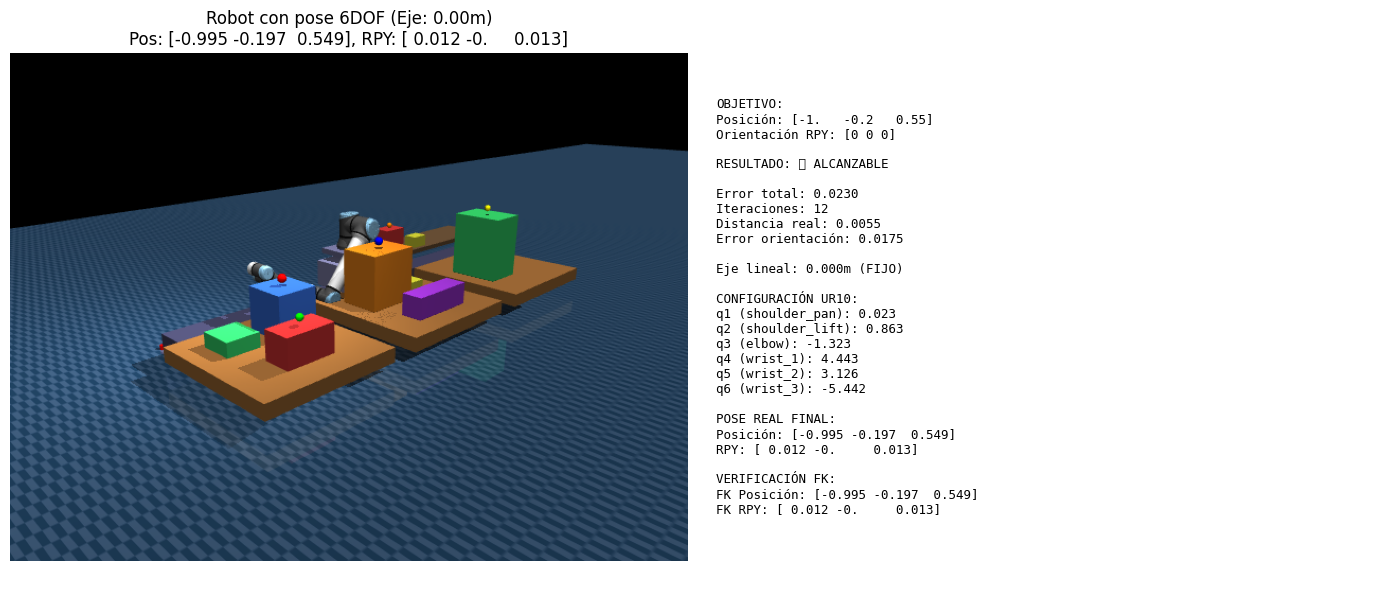

In [16]:
punto_prueba =  [-1.0, -0.2, 0.55]
orientacion_paralela = [0, -0, 0]  # Paralelo al piso
    
resultado = verificar_punto_corregido(
        model, data, 
        punto_prueba, 
        orientacion_paralela, 
        posicion_eje=0
    )

🤖 Verificador IK CORREGIDO con Cinemática Directa

--- PRUEBA: ORIENTACIÓN PARALELA AL PISO ---
🎯 Verificando punto: [0.5, -0.2, 1.8]
🔄 Con orientación RPY: [0 0 0] rad
🔒 Eje lineal fijado en: 0.000m
📍 Posición inicial REAL: [-1.184 -0.174  0.561]
📐 RPY inicial REAL: [3.142 0.    0.   ]
🎯 Cuaternión objetivo: [1. 0. 0. 0.]
🔄 Usando configuración inicial por defecto
📍 Posición inicial del efector: [-1.000e-03 -1.740e-01  1.985e+00]
📏 Distancia inicial al objetivo: 0.5348
   Iteración 0: error_pos = 0.5348
✅ Convergencia alcanzada en iteración 9
🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:
  Config completa: [ 0.    -0.052 -1.715 -0.668 -0.801  3.183 -0.045]
  FK posición: [ 0.498 -0.2    1.8  ]
  FK RPY: [ 0.002 -0.002 -0.011]
  Coincide con final: True
📊 Resultados:
  IK exitoso: ✅ Sí
  Error total: 0.0135
  Iteraciones: 9
  Eje lineal: 0.000m -> 0.000m ✅
  Configuración UR10: [-0.052 -1.715 -0.668 -0.801  3.183 -0.045]
  Posición objetivo: [ 0.5 -0.2  1.8]
  Posición final: [ 0.498 -0.2    1.8 

C:\Users\samue\AppData\Local\Temp\ipykernel_19140\374327694.py:451: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


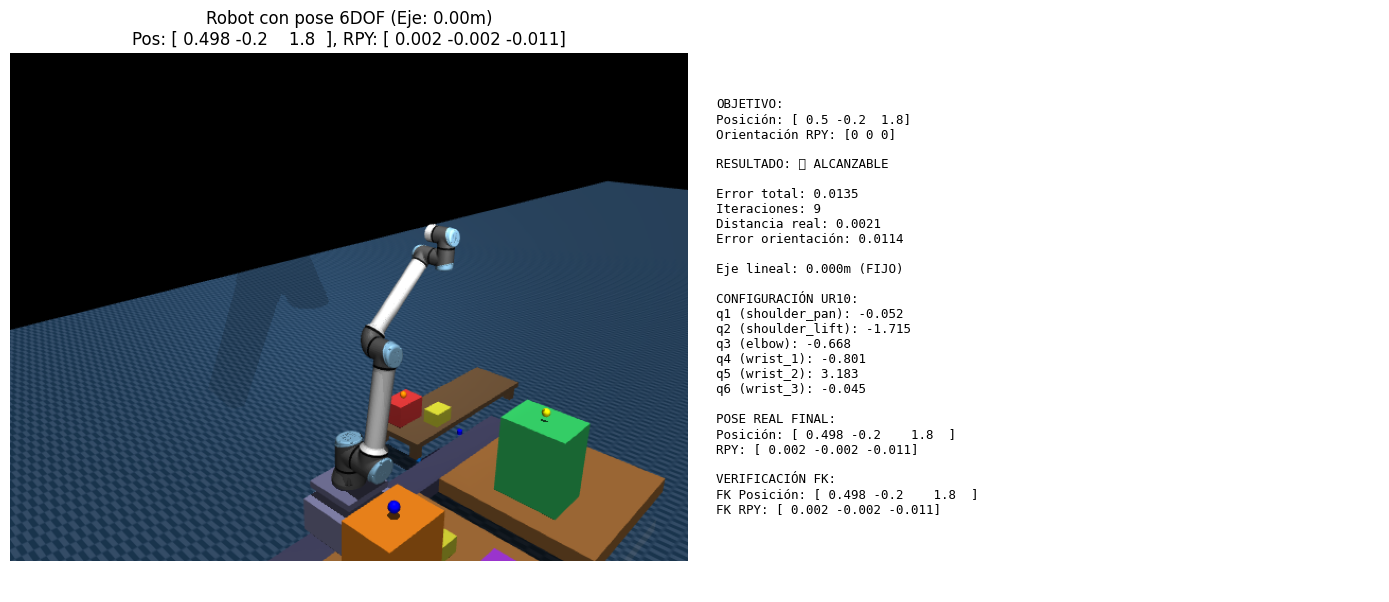


--- PRUEBA: SOLO POSICIÓN ---
🎯 Verificando punto: [0.3, -0.3, 1.7]
🔒 Eje lineal fijado en: 0.000m
📍 Posición inicial REAL: [-1.184 -0.174  0.561]
📐 RPY inicial REAL: [3.142 0.    0.   ]
🔄 Usando configuración inicial por defecto
📍 Posición inicial del efector: [-1.000e-03 -1.740e-01  1.985e+00]
📏 Distancia inicial al objetivo: 0.4333
   Iteración 0: error_pos = 0.4333
✅ Convergencia alcanzada en iteración 6
🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:
  Config completa: [   0.      56.141 -372.8    490.594 1290.353    0.       0.   ]
  FK posición: [ 0.291 -0.315  1.693]
  FK RPY: [-3.142 -0.714 -0.407]
  Coincide con final: True
📊 Resultados:
  IK exitoso: ✅ Sí
  Error total: 0.0189
  Iteraciones: 6
  Eje lineal: 0.000m -> 0.000m ✅
  Configuración UR10: [  56.141 -372.8    490.594 1290.353    0.       0.   ]
  Posición objetivo: [ 0.3 -0.3  1.7]
  Posición final: [ 0.291 -0.315  1.693]
  Distancia real: 0.0189
  🎉 ¡Punto ALCANZABLE!


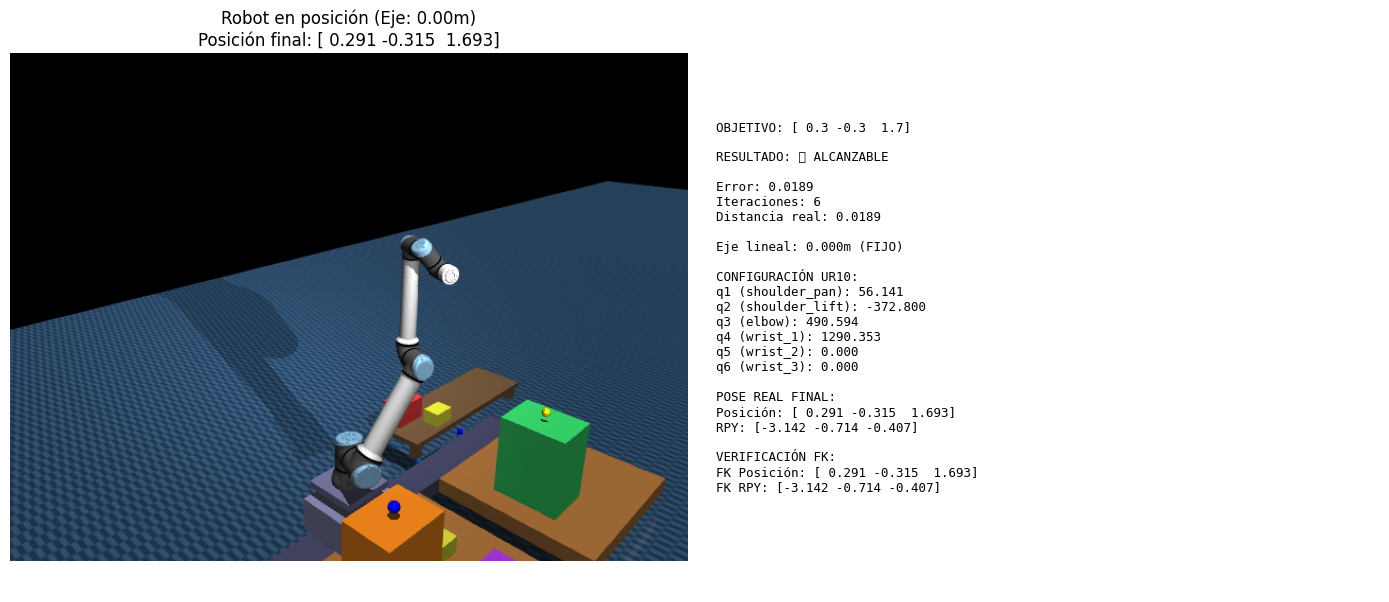


--- PRUEBA: VERIFICAR CONFIGURACIÓN CONOCIDA ---
Config: [ 0.5   0.   -1.57  0.   -1.57  0.    0.  ]
FK Posición: [ 0.499 -0.174  1.985]
FK RPY: [0.000e+00 2.000e-03 3.142e+00]

✅ ¡Verificación completada con cinemática directa!


In [19]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt

def forward_kinematics(model, data, q_config, body_name="wrist_3_link"):
    """
    Calcula la cinemática directa - establece configuración y retorna pose
    
    Args:
        model: modelo de MuJoCo
        data: datos de MuJoCo
        q_config: configuración de joints [linear, q1, q2, q3, q4, q5, q6]
        body_name: nombre del cuerpo a evaluar
    
    Returns:
        pos: posición [x, y, z]
        quat: cuaternión [w, x, y, z]
        rpy: ángulos RPY [roll, pitch, yaw]
    """
    # Nombres de todos los joints en orden
    joint_names = [
        "linear_joint",
        "shoulder_pan_joint",
        "shoulder_lift_joint", 
        "elbow_joint",
        "wrist_1_joint",
        "wrist_2_joint",
        "wrist_3_joint"
    ]
    
    # Establecer configuración
    for i, joint_name in enumerate(joint_names):
        if i < len(q_config):
            joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
            data.qpos[joint_id] = q_config[i]
    
    # Calcular cinemática directa
    mujoco.mj_forward(model, data)
    
    # Obtener pose del cuerpo especificado
    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, body_name)
    pos = data.xpos[body_id].copy()
    quat = data.xquat[body_id].copy()
    rpy = quaternion_to_rpy(quat)
    
    return pos, quat, rpy

def solve_ik_6dof_corrected(model, data, goal_pos, goal_quat=None, q_init=None, max_iter=100, tolerance=0.02, alpha_pos=1.0, alpha_rot=0.5):
    """
    Cinemática inversa CORREGIDA para posición y orientación 
    
    Args:
        model: modelo de MuJoCo
        data: datos de MuJoCo
        goal_pos: posición objetivo [x, y, z]
        goal_quat: orientación objetivo [w, x, y, z] (opcional)
        q_init: configuración inicial [q1, q2, q3, q4, q5, q6] para UR10 (opcional)
        max_iter: máximo número de iteraciones
        tolerance: tolerancia de error
        alpha_pos: ganancia para posición
        alpha_rot: ganancia para orientación
    """
    jacp = np.zeros((3, model.nv))  # Jacobiano de posición
    jacr = np.zeros((3, model.nv))  # Jacobiano de rotación
    end_effector_id = model.body('wrist_3_link').id
    
    # IDs de los joints del UR10 (SIN el eje lineal)
    ur10_joint_names = [
        "shoulder_pan_joint",
        "shoulder_lift_joint", 
        "elbow_joint",
        "wrist_1_joint",
        "wrist_2_joint",
        "wrist_3_joint"
    ]
    
    ur10_joint_ids = []
    for name in ur10_joint_names:
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        ur10_joint_ids.append(joint_id)
    
    # Guardar posición inicial del eje lineal
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    posicion_eje_lineal = data.qpos[linear_joint_id]
    
    # CONFIGURACIÓN INICIAL para los joints del UR10
    if q_init is not None:
        print(f"🎯 Usando configuración inicial personalizada: {np.round(q_init, 3)}")
        # Aplicar configuración inicial especificada
        for i, joint_id in enumerate(ur10_joint_ids):
            if i < len(q_init):
                data.qpos[joint_id] = q_init[i]
    else:
        print(f"🔄 Usando configuración inicial por defecto")
        # Configuración inicial por defecto (posición extendida)
        config_default = [0, -1.57, 0, -1.57, 0, 0]
        for i, joint_id in enumerate(ur10_joint_ids):
            data.qpos[joint_id] = config_default[i]
    
    # Actualizar simulación con configuración inicial
    mujoco.mj_forward(model, data)
    pos_inicial = data.body(end_effector_id).xpos.copy()
    print(f"📍 Posición inicial del efector: {np.round(pos_inicial, 3)}")
    print(f"📏 Distancia inicial al objetivo: {np.linalg.norm(np.array(goal_pos) - pos_inicial):.4f}")
    
    for iteration in range(max_iter):
        # IMPORTANTE: Actualizar la simulación ANTES de calcular errores
        mujoco.mj_forward(model, data)
        
        # Posición actual del efector final
        current_pos = data.body(end_effector_id).xpos.copy()
        current_quat = data.body(end_effector_id).xquat.copy()  # [w, x, y, z]
        
        # Error de posición
        error_pos = np.subtract(goal_pos, current_pos)
        error_pos_norm = np.linalg.norm(error_pos)
        
        # Error de orientación (si se especifica)
        if goal_quat is not None:
            # Convertir cuaterniones a vectores de rotación
            error_rot = quaternion_error(goal_quat, current_quat)
            error_rot_norm = np.linalg.norm(error_rot)
            
            # Error total
            total_error = error_pos_norm + error_rot_norm
            
            # Verificar convergencia
            if error_pos_norm < tolerance and error_rot_norm < tolerance:
                print(f"✅ Convergencia alcanzada en iteración {iteration}")
                return True, total_error, iteration
        else:
            # Solo posición
            if error_pos_norm < tolerance:
                print(f"✅ Convergencia alcanzada en iteración {iteration}")
                return True, error_pos_norm, iteration
        
        # Mostrar progreso cada 20 iteraciones
        if iteration % 20 == 0:
            print(f"   Iteración {iteration}: error_pos = {error_pos_norm:.4f}")
        
        # Calcular Jacobianos EN LA POSICIÓN ACTUAL
        mujoco.mj_jac(model, data, jacp, jacr, current_pos, end_effector_id)
        
        # Extraer SOLO las columnas del Jacobiano correspondientes a los joints del UR10
        jac_pos_ur10 = jacp[:, ur10_joint_ids]
        jac_rot_ur10 = jacr[:, ur10_joint_ids]
        
        if goal_quat is not None:
            # IK con posición y orientación (6 DOF)
            # Combinar errores y jacobianos
            error_combined = np.concatenate([alpha_pos * error_pos, alpha_rot * error_rot])
            jac_combined = np.vstack([alpha_pos * jac_pos_ur10, alpha_rot * jac_rot_ur10])
            
            # Pseudoinversa amortiguada
            damping = 1e-4
            jac_T = jac_combined.T
            jac_pinv = jac_T @ np.linalg.inv(jac_combined @ jac_T + damping * np.eye(6))
            delta_q_ur10 = jac_pinv @ error_combined
        else:
            # Solo posición (3 DOF)
            jac_pinv = np.linalg.pinv(jac_pos_ur10)
            delta_q_ur10 = alpha_pos * jac_pinv @ error_pos
        
        # Aplicar paso más conservador
        step_size = 0.5
        delta_q_ur10 = step_size * delta_q_ur10
        
        # Actualizar SOLO los joints del UR10
        for i, joint_id in enumerate(ur10_joint_ids):
            data.qpos[joint_id] += delta_q_ur10[i]
        
        # MANTENER el eje lineal fijo
        data.qpos[linear_joint_id] = posicion_eje_lineal
    
    # No convergió - calcular error final
    mujoco.mj_forward(model, data)
    current_pos = data.body(end_effector_id).xpos
    error_pos_norm = np.linalg.norm(np.subtract(goal_pos, current_pos))
    
    print(f"❌ No convergió después de {max_iter} iteraciones")
    
    if goal_quat is not None:
        current_quat = data.body(end_effector_id).xquat
        error_rot = quaternion_error(goal_quat, current_quat)
        error_rot_norm = np.linalg.norm(error_rot)
        total_error = error_pos_norm + error_rot_norm
        return False, total_error, max_iter
    else:
        return False, error_pos_norm, max_iter

def quaternion_error(q_target, q_current):
    """Calcula el error de orientación entre dos cuaterniones"""
    # Normalizar cuaterniones
    q_target = q_target / np.linalg.norm(q_target)
    q_current = q_current / np.linalg.norm(q_current)
    
    # Cuaternión de error: q_error = q_target * q_current^(-1)
    q_current_inv = np.array([q_current[0], -q_current[1], -q_current[2], -q_current[3]])
    q_error = quaternion_multiply(q_target, q_current_inv)
    
    # Convertir a vector de rotación (parte vectorial * 2)
    if q_error[0] < 0:  # Asegurar que w >= 0 para minimizar ángulo
        q_error = -q_error
    
    # Error como vector de rotación
    error_rot = 2.0 * q_error[1:4]  # [x, y, z] components
    return error_rot

def quaternion_multiply(q1, q2):
    """Multiplica dos cuaterniones [w, x, y, z]"""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    
    return np.array([w, x, y, z])

def rpy_to_quaternion(roll, pitch, yaw):
    """Convierte ángulos RPY (radianes) a cuaternión [w, x, y, z]"""
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    
    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy
    
    return np.array([w, x, y, z])

def quaternion_to_rpy(quat):
    """Convierte cuaternión [w, x, y, z] a ángulos RPY"""
    w, x, y, z = quat
    
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    
    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp)
    else:
        pitch = np.arcsin(sinp)
    
    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    
    return np.array([roll, pitch, yaw])

def verificar_punto_corregido(model, data, punto, orientacion=None, posicion_eje=0.0):
    """
    Verifica un punto [x,y,z] con orientación opcional - VERSIÓN CORREGIDA
    """
    print(f"🎯 Verificando punto: {punto}")
    if orientacion is not None:
        print(f"🔄 Con orientación RPY: {np.round(orientacion, 3)} rad")
    
    # Resetear
    mujoco.mj_resetData(model, data)
    
    # FIJAR el eje lineal ANTES de empezar
    fijar_eje_lineal(model, data, posicion_eje)
    mujoco.mj_forward(model, data)
    
    # Estado inicial REAL (después de aplicar configuración)
    pos_inicial = data.body('wrist_3_link').xpos.copy()
    quat_inicial = data.body('wrist_3_link').xquat.copy()
    rpy_inicial = quaternion_to_rpy(quat_inicial)
    
    print(f"📍 Posición inicial REAL: {np.round(pos_inicial, 3)}")
    print(f"📐 RPY inicial REAL: {np.round(rpy_inicial, 3)}")
    
    # Convertir orientación a cuaternión si se especifica
    goal_quat = None
    if orientacion is not None:
        goal_quat = rpy_to_quaternion(orientacion[0], orientacion[1], orientacion[2])
        print(f"🎯 Cuaternión objetivo: {np.round(goal_quat, 3)}")
    
    # Resolver IK con orientación
    exito, error, iteraciones = solve_ik_6dof_corrected(model, data, punto, goal_quat)
    
    # ESTADO FINAL DESPUÉS DE IK
    mujoco.mj_forward(model, data)  # Asegurar que la simulación esté actualizada
    
    # Verificar que el eje lineal NO se movió
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    posicion_final_eje = data.qpos[linear_joint_id]
    
    # Obtener configuración final del UR10
    ur10_joint_names = [
        "shoulder_pan_joint", "shoulder_lift_joint", "elbow_joint",
        "wrist_1_joint", "wrist_2_joint", "wrist_3_joint"
    ]
    
    config_ur10 = []
    for name in ur10_joint_names:
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        config_ur10.append(data.qpos[joint_id])
    
    # Posición y orientación final DESPUÉS de IK
    pos_final = data.body('wrist_3_link').xpos.copy()
    quat_final = data.body('wrist_3_link').xquat.copy()
    rpy_final = quaternion_to_rpy(quat_final)
    
    # VERIFICAR CINEMÁTICA DIRECTA
    config_completa = [posicion_eje] + config_ur10
    pos_fk, quat_fk, rpy_fk = forward_kinematics(model, data, config_completa)
    
    print(f"🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:")
    print(f"  Config completa: {np.round(config_completa, 3)}")
    print(f"  FK posición: {np.round(pos_fk, 3)}")
    print(f"  FK RPY: {np.round(rpy_fk, 3)}")
    print(f"  Coincide con final: {np.allclose(pos_final, pos_fk, atol=1e-3)}")
    
    distancia_real = np.linalg.norm(np.array(punto) - pos_final)
    
    # Error de orientación
    error_orientacion = 0.0
    if orientacion is not None:
        error_orientacion = np.linalg.norm(np.array(orientacion) - rpy_final)
    
    # Crear renderer
    renderer = mujoco.Renderer(model, height=480, width=640)
    
    # Configurar cámara
    camera = mujoco.MjvCamera()
    mujoco.mjv_defaultFreeCamera(model, camera)
    camera.distance = 3.0
    camera.azimuth = 45
    camera.elevation = -20
    camera.lookat = [0, 0, 1.5]
    
    # IMPORTANTE: Aplicar configuración antes de capturar imagen
    for i, name in enumerate(["linear_joint"] + ur10_joint_names):
        joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
        data.qpos[joint_id] = config_completa[i]
        data.ctrl[i] = config_completa[i]  # También establecer control
    
    mujoco.mj_forward(model, data)
    mujoco.mj_step(model, data)
    
    # Capturar imagen
    renderer.update_scene(data, camera)
    imagen = renderer.render()
    
    # Mostrar resultados
    print(f"📊 Resultados:")
    print(f"  IK exitoso: {'✅ Sí' if exito else '❌ No'}")
    print(f"  Error total: {error:.4f}")
    print(f"  Iteraciones: {iteraciones}")
    print(f"  Eje lineal: {posicion_eje:.3f}m -> {posicion_final_eje:.3f}m {'✅' if abs(posicion_final_eje - posicion_eje) < 0.001 else '❌'}")
    print(f"  Configuración UR10: {np.round(config_ur10, 3)}")
    print(f"  Posición objetivo: {np.round(punto, 3)}")
    print(f"  Posición final: {np.round(pos_final, 3)}")
    print(f"  Distancia real: {distancia_real:.4f}")
    
    if orientacion is not None:
        print(f"  RPY objetivo: {np.round(orientacion, 3)}")
        print(f"  RPY final: {np.round(rpy_final, 3)}")
        print(f"  Error orientación: {error_orientacion:.4f}")
    
    if distancia_real < 0.05 and (orientacion is None or error_orientacion < 0.1):
        print(f"  🎉 ¡Punto ALCANZABLE!")
    else:
        print(f"  ⚠️  Punto/orientación DIFÍCIL de alcanzar")
    
    # Mostrar imagen
    plt.figure(figsize=(14, 6))
    
    # Imagen del robot
    plt.subplot(1, 2, 1)
    plt.imshow(imagen)
    if orientacion is not None:
        plt.title(f"Robot con pose 6DOF (Eje: {posicion_eje:.2f}m)\nPos: {np.round(pos_final, 3)}, RPY: {np.round(rpy_final, 3)}")
    else:
        plt.title(f"Robot en posición (Eje: {posicion_eje:.2f}m)\nPosición final: {np.round(pos_final, 3)}")
    plt.axis('off')
    
    # Información
    plt.subplot(1, 2, 2)
    if orientacion is not None:
        info_text = f"""OBJETIVO:
Posición: {np.round(punto, 3)}
Orientación RPY: {np.round(orientacion, 3)}

RESULTADO: {'✅ ALCANZABLE' if exito else '❌ NO ALCANZABLE'}

Error total: {error:.4f}
Iteraciones: {iteraciones}
Distancia real: {distancia_real:.4f}
Error orientación: {error_orientacion:.4f}

Eje lineal: {posicion_eje:.3f}m (FIJO)

CONFIGURACIÓN UR10:
q1 (shoulder_pan): {config_ur10[0]:.3f}
q2 (shoulder_lift): {config_ur10[1]:.3f}
q3 (elbow): {config_ur10[2]:.3f}
q4 (wrist_1): {config_ur10[3]:.3f}
q5 (wrist_2): {config_ur10[4]:.3f}
q6 (wrist_3): {config_ur10[5]:.3f}

POSE REAL FINAL:
Posición: {np.round(pos_final, 3)}
RPY: {np.round(rpy_final, 3)}

VERIFICACIÓN FK:
FK Posición: {np.round(pos_fk, 3)}
FK RPY: {np.round(rpy_fk, 3)}"""
    else:
        info_text = f"""OBJETIVO: {np.round(punto, 3)}

RESULTADO: {'✅ ALCANZABLE' if exito else '❌ NO ALCANZABLE'}

Error: {error:.4f}
Iteraciones: {iteraciones}
Distancia real: {distancia_real:.4f}

Eje lineal: {posicion_eje:.3f}m (FIJO)

CONFIGURACIÓN UR10:
q1 (shoulder_pan): {config_ur10[0]:.3f}
q2 (shoulder_lift): {config_ur10[1]:.3f}
q3 (elbow): {config_ur10[2]:.3f}
q4 (wrist_1): {config_ur10[3]:.3f}
q5 (wrist_2): {config_ur10[4]:.3f}
q6 (wrist_3): {config_ur10[5]:.3f}

POSE REAL FINAL:
Posición: {np.round(pos_final, 3)}
RPY: {np.round(rpy_final, 3)}

VERIFICACIÓN FK:
FK Posición: {np.round(pos_fk, 3)}
FK RPY: {np.round(rpy_fk, 3)}"""
    
    plt.text(0.02, 0.5, info_text, fontsize=9, verticalalignment='center', 
             transform=plt.gca().transAxes, family='monospace')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'punto': punto,
        'orientacion': orientacion,
        'exito': exito,
        'error': error,
        'distancia_real': distancia_real,
        'error_orientacion': error_orientacion,
        'pos_final': pos_final,
        'rpy_final': rpy_final,
        'config_ur10': config_ur10,
        'config_completa': config_completa,
        'fk_pos': pos_fk,
        'fk_rpy': rpy_fk,
        'eje_se_movio': abs(posicion_final_eje - posicion_eje) > 0.001
    }

def fijar_eje_lineal(model, data, posicion=0.0):
    """Fija el eje lineal en una posición específica"""
    linear_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, "linear_joint")
    data.qpos[linear_joint_id] = posicion
    data.ctrl[0] = posicion
    print(f"🔒 Eje lineal fijado en: {posicion:.3f}m")

# ===== EJEMPLO DE USO =====
if __name__ == "__main__":
    # Cargar modelo
    model = mujoco.MjModel.from_xml_path("wherehouse_system.xml")
    data = mujoco.MjData(model)
    
    print("🤖 Verificador IK CORREGIDO con Cinemática Directa")
    print("=" * 55)
    
    # Ejemplo 1: Verificar orientación paralela al piso
    print(f"\n--- PRUEBA: ORIENTACIÓN PARALELA AL PISO ---")
    punto_prueba = [0.5, -0.2, 1.8]
    orientacion_paralela = [0, 0, 0]  # Paralelo al piso
    
    resultado = verificar_punto_corregido(
        model, data, 
        punto_prueba, 
        orientacion_paralela, 
        posicion_eje=0.0
    )
    
    # Ejemplo 2: Solo posición
    print(f"\n--- PRUEBA: SOLO POSICIÓN ---")
    punto_simple = [0.3, -0.3, 1.7]
    
    resultado2 = verificar_punto_corregido(
        model, data, 
        punto_simple, 
        posicion_eje=0.0
    )
    
    # Ejemplo 3: Verificar configuración conocida
    print(f"\n--- PRUEBA: VERIFICAR CONFIGURACIÓN CONOCIDA ---")
    config_conocida = [0.5, 0, -1.57, 0, -1.57, 0, 0]  # [linear + UR10]
    pos_fk, quat_fk, rpy_fk = forward_kinematics(model, data, config_conocida)
    
    print(f"Config: {np.round(config_conocida, 3)}")
    print(f"FK Posición: {np.round(pos_fk, 3)}")
    print(f"FK RPY: {np.round(rpy_fk, 3)}")
    
    print(f"\n✅ ¡Verificación completada con cinemática directa!")

🎯 Verificando punto: [-1.0, -0.2, 0.55]
🔄 Con orientación RPY: [0 0 0] rad
🔒 Eje lineal fijado en: 0.000m
📍 Posición inicial REAL: [-1.184 -0.174  0.561]
📐 RPY inicial REAL: [3.142 0.    0.   ]
🎯 Cuaternión objetivo: [1. 0. 0. 0.]
🔄 Usando configuración inicial por defecto
📍 Posición inicial del efector: [-1.000e-03 -1.740e-01  1.985e+00]
📏 Distancia inicial al objetivo: 1.7486
   Iteración 0: error_pos = 1.7486
✅ Convergencia alcanzada en iteración 10
🔍 VERIFICACIÓN CINEMÁTICA DIRECTA:
  Config completa: [  0.      0.026  -5.716   5.128  13.086   3.154 -15.778]
  FK posición: [-0.996 -0.2    0.549]
  FK RPY: [-0.001 -0.001  0.014]
  Coincide con final: True
📊 Resultados:
  IK exitoso: ✅ Sí
  Error total: 0.0186
  Iteraciones: 10
  Eje lineal: 0.000m -> 0.000m ✅
  Configuración UR10: [  0.026  -5.716   5.128  13.086   3.154 -15.778]
  Posición objetivo: [-1.   -0.2   0.55]
  Posición final: [-0.996 -0.2    0.549]
  Distancia real: 0.0045
  RPY objetivo: [0 0 0]
  RPY final: [-0.001 -0.

C:\Users\samue\AppData\Local\Temp\ipykernel_19140\374327694.py:451: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


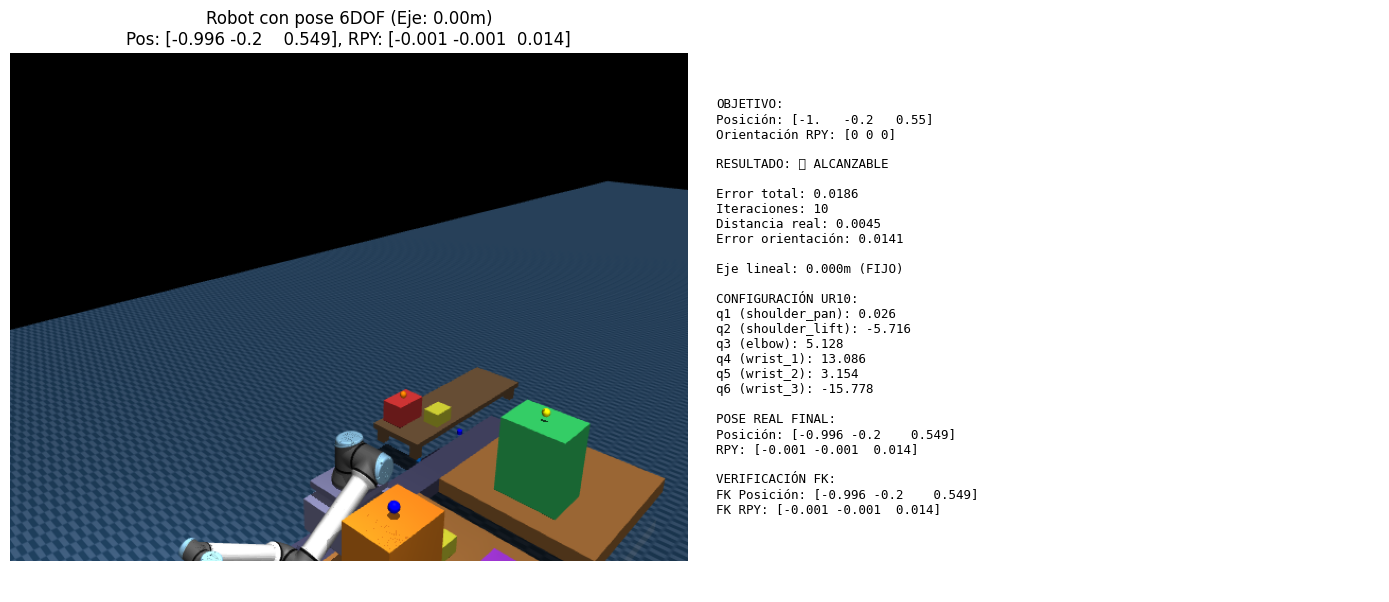

In [20]:
punto_prueba =  [-1.0, -0.2, 0.55]
orientacion_paralela = [0, -0, 0]  # Paralelo al piso
    
resultado = verificar_punto_corregido(
        model, data, 
        punto_prueba, 
        orientacion_paralela, 
        posicion_eje=0
    )

In [ ]:
    # Ejemplo 2: Solo posición
    print(f"\n--- PRUEBA: SOLO POSICIÓN ---")
    punto_simple = [0.3, -0.3, 1.7]
    
    resultado2 = verificar_punto_corregido(
        model, data, 
        punto_simple, 
        posicion_eje=0.0
    )